###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D axisymmetric spherical SH finite difference modelling  - Ganymede

Does a habitable liquid ocean exist beneath the ice crust of Jupiters moon Ganymede? By global axisymmetric SH modelling we will investigate if a single geophone on Ganymedes surface would be able to detect a possible ocean.

## The moons of Jupiter

In the year 1610 [Galileo Galilei](https://en.wikipedia.org/wiki/Galileo_Galilei) pointed his simple telescope to the planet Jupiter and discovered 4 nearby "stars", changing their position with respect to Jupiter during the following nights. These largest [Galilean moons](https://en.wikipedia.org/wiki/Galilean_moons) of Jupiter 
where later named Io, Europa, Ganymede and Callisto. Starting with the [Voyager probes](https://en.wikipedia.org/wiki/Voyager_program) in the 1970s and later missions revealed dynamic worlds:

<img src="images/Galilean_moons.jpg" width="100%">

with active vulcanism on Io and the ice moons Eurpa, Ganymede and Callisto showing complex surface features.

## A liquid ocean on Ganymede?

The strong tidal forces of Jupiter acting on the moon Ganymede are a possible heat source leading to liquid ocean layers below the ice crust, as shown in this [artistic sketch](https://www.jpl.nasa.gov/spaceimages/details.php?id=PIA18005) by NASA/JPL: 

<img src="images/InsideGanymede.jpg" width="100%">

Ganymede could consists of a "sandwich" of multiple layers of ice and liquid oceans with variable salinity. Liquid water is an important ingredient of life, making the Jupiter moon Ganymede an interesting target for future space missions. Recent numerical studies focussed on the computation of the seismicity of the icy moons [(Panning et al. 2017)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2017JE005332), noise sources related to ice quakes, vulcanism, water currents and possible vital signs [(Vance et al. 2018)](https://arxiv.org/abs/1610.10067) and the influence of potential liquid oceans on seismic wave propagation [(Stähler et al. 2017)](https://arxiv.org/abs/1705.03500), In this exercise we investigate, if we can distinguish between a solid ice crust and liquid ocean with one SH-seismometer placed on the surface of Ganymede? Let's do some global axisymmetric SH modelling to answer this question ...

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import interpolate

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

As usual, we first define the modelling parameters for an axisymmetric Ganymede model. Unfortunately, Ganymede seem to have to solid core, which would require a special treatment of the centre to avoid the singularity at $r = 0\; m$. For simplicity, we assume that Ganymedes inner core with a radius of roughly 700 km is liquid, so we can handle the CMB as free-surface boundary.

In [3]:
# Definition of modelling parameters
# ----------------------------------
rcore = 693.0 * 1000.0      # Ganymede fluid core radius [m]
rplanet = 2634.1 * 1000.0   # Ganymede radius [m]

nr = 400      # number of spatial gridpoints in r-direction
dr = (rplanet - rcore) / nr # spatial gridpoint distance in r-direction

# calculate dtheta based on dr
dtheta = dr / rcore
ntheta = (int) (np.pi / dtheta)  # number of spatial gridpoints in theta-direction
ntheta += 2

# Define Ganymede model filename
name_model = "ganymede_model/ganymede_model.dat"

# Acquisition geometry
tmax = 2000.0           # maximum recording time of the seismogram (s)

isnap = 5  # snapshot interval (timesteps)

... next we read the 1D Ganymede model based on [Vance et al. (2017)](https://arxiv.org/abs/1705.03999). Matlab codes by Steven Vance to create 1D Ganymede models describing basic physical properties (sound speeds, attenuation, and electrical conductivities), incorporating self-consistent thermodynamics for the fluid, rock, and mineral phases, are available [here](https://github.com/vancesteven/PlanetProfile).

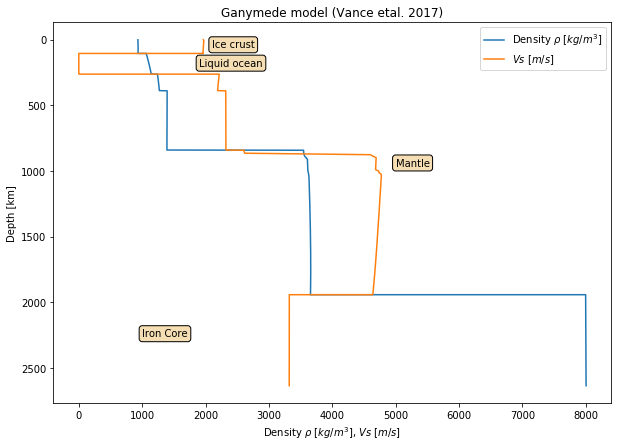

In [4]:
# Read and plot moon model
# ------------------------
model = np.loadtxt(name_model, delimiter=' ', skiprows=1)

radius = model[:,0] # radius [m]
rho1D = model[:,1]  # density [kg/m^3]
vs1D = model[:,3]   # S-wave velocity model [m/s]

# Define figure size
rcParams['figure.figsize'] = 10, 7

depth = radius[0] - radius

plt.plot(rho1D,depth/1000, label=r"Density $\rho$ [$kg/m^3$]")
plt.plot(vs1D,depth/1000, label=r"$Vs$ [$m/s$]")

# Annotate model
# --------------
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat')

# place a text box in upper left in axes coords
plt.text(2100, 0, "Ice crust", fontsize=10, verticalalignment='top', bbox=props)
plt.text(1900, 140, "Liquid ocean", fontsize=10, verticalalignment='top', bbox=props)
plt.text(5000, 900, "Mantle", fontsize=10, verticalalignment='top', bbox=props)
plt.text(1000, 2200, "Iron Core", fontsize=10, verticalalignment='top', bbox=props)

plt.title("Ganymede model (Vance etal. 2017)")
plt.ylabel("Depth [km]")
plt.xlabel(r"Density $\rho$ [$kg/m^3$], $Vs$ [$m/s$]")
plt.gca().invert_yaxis()
plt.legend()

plt.show()

The model consists of an ice crust, liquid ocean, mantle and Iron core. For simplicity, we will assume, that the iron core is liquid, so our model will only be defined above the Core-Mantle-Boundary (CMB). 

Based on the spatial model discretization defined above, we calculate the centre frequency of the source wavelet, assuming $N_\lambda=12$ gridpoints per dominant wavelength.

In [5]:
# Calculate dominant frequency of the source wavelet
# --------------------------------------------------
Nlam = 12                     # number of grid points per dominant wavelength
vsmin = vs1D[0]               # minimum S-wave velocity [m/s]
f0 = vsmin / (Nlam * dr)      # centre frequency of the source wavelet [Hz]
print('f0 = ', f0, ' Hz')
print('Period T = ', 1/f0, ' s')
t0   = 4. / f0                # source time shift (s)

f0 =  0.033752844607009766  Hz
Period T =  29.627132517071487  s


For the axisymmetric SH modelling, we use the same FD code as for the earth PREM and moon modelling. First, we define the particle velocity $v_\phi$ update ...

In [6]:
# Particle velocity vphi update
# -----------------------------
@jit(nopython=True) # use JIT for C-performance
def update_vel(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, rho, r, theta):
    
    # 2nd order FD operator   
    for i in range(1, ntheta - 1):
        for j in range(1, nr - 1):

            # Calculate spatial derivatives  (2nd order operator)           
            srp_r = (srp[i,j] - srp[i,j-1]) / dr
            stp_t = (stp[i,j] - stp[i-1,j]) / (r[j] * dtheta)            

            # Average stress wavefields at point (i,j)
            vphi_avg = (((srp[i,j] + srp[i,j-1]) / 2) * 3 + 
                         (stp[i,j] + stp[i-1,j]) / np.tan(theta[i])
                       ) / r[j]
            
            # Update particle velocities vphi            
            vphi[i,j] = vphi[i,j] + (dt/rho[i,j]) * (srp_r + stp_t + vphi_avg)                               
                
    return vphi

... then update the shear stress components $\sigma_{r\phi}$ and $\sigma_{\theta\phi}$ ...

In [7]:
# Shear stress srp, stp updates
# -----------------------------
@jit(nopython=True) # use JIT for C-performance
def update_stress(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, mur, mutheta, thetah, r, rh):
    
    # 2nd order FD operator
    for i in range(1, ntheta - 1):
        for j in range(1, nr - 1):

            # Calculate spatial derivatives (2nd order operator)
            vphi_r = (vphi[i,j + 1] - vphi[i,j]) / dr
            vphi_theta = (vphi[i + 1,j] - vphi[i,j]) / (dtheta * r[j])

            # calculate vphi at (i,j+1/2)
            vphih = (vphi[i,j + 1] + vphi[i,j]) / (2 * rh[j])
            
            # calculate vphi at (i+1/2,j)
            vphithetah = (vphi[i + 1,j] + vphi[i,j]) / (2 * r[j] * np.tan(thetah[i]))
            
            # Update shear stresses
            srp[i,j] = srp[i,j] + dt * mur[i,j] * (vphi_r - vphih)
            stp[i,j] = stp[i,j] + dt * mutheta[i,j] * (vphi_theta - vphithetah)                    
    
    return srp, stp

... and averaging the shear modulus, where I additionally checked if the shear modulus is not equal 0 to avoid further trouble during the FD modelling ...

In [8]:
# Harmonic averages of shear modulus
# ----------------------------------
@jit(nopython=True) # use JIT for C-performance
def shear_avg(mu, nr, ntheta, mur, mutheta):
    
    for i in range(1, ntheta - 1):
        for j in range(1, nr - 1):
            
            # Calculate harmonic averages of shear moduli                                
            
            # Check if mu=0 on the FD grid
            if(mu[i+1,j]<1e-20 or mu[i,j]<1e-20):
                mutheta[i,j] = 0.0
            else:
                mutheta[i,j] = 2 / (1 / mu[i + 1,j] + 1 / mu[i,j])        
                    
            if(mu[i,j+1]<1e-20 or mu[i,j]<1e-20):
                mur[i,j] = 0.0
            else:
                mur[i,j] = 2 / (1 / mu[i,j + 1] + 1 / mu[i,j])
        
    return mur, mutheta

Finally, we assemble all parts into the 2D SH axisymmetric FD code:

In [9]:
# 2D SH axisymmetric spherical wave propagation (Finite Difference Solution) 
# --------------------------------------------------------------------------
def FD_2D_SH_JIT(dt,dr,dtheta,f0,vs,rho,nr,ntheta,clip,zsrc):        
            
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)    

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))
    
    # Initialize coordinates
    # ----------------------
    r    = np.arange(nr)
    r    = rcore + r * dr   # coordinates in r-direction (m)
    rh   = r + (dr/2)       # r-direction coordinates shifted by half a gridpoint (m)

    theta    = np.arange(ntheta)
    theta    = theta * dtheta      # coordinates in theta-direction (rad)
    thetah   = theta + (dtheta/2)  # theta-direction shifted by half a gridpoint (rad)
    
    thetamax = np.max(theta)
    rmax = np.max(r)
    
    # rectangular plot of polar data
    r1, theta1 = np.meshgrid(r, np.hstack((theta,theta + np.pi)))    
    
    # Define source position    
    isrc =  2   # source location in theta-direction [gridpoints]
    jsrc =  (int)((r[-1] - rcore - zsrc)/dr) # source location in r-direction [gridpoints]    
    
    # Place receivers two grid points below the earth surface
    # and at all grid points in theta direction
    jr = nr - 2            # receiver location in r-direction [gridpoints]
    
    # Initialize empty wavefield arrays
    # ---------------------------------
    vphi    = np.zeros((ntheta,nr))  # particle velocity vphi
    srp     = np.zeros((ntheta,nr))  # shear stress srp
    stp     = np.zeros((ntheta,nr))  # shear stress stp    
    vphi1   = np.vstack((vphi,vphi)) # vphi mirrored at the symmetry axis
    
    # Define S-wave velocity model for visualization
    vs1     = np.vstack((vs,np.flipud(vs)))
    
    # harmonic average of shear moduli
    # --------------------------------
    mu    = np.zeros((ntheta,nr))
    mu    = rho * vs ** 2   # calculate shear modulus        
    
    mur       = mu   # initialize harmonic average mur
    mutheta   = mu   # initialize harmonic average mutheta
    mur, mutheta = shear_avg(mu, nr, ntheta, mur, mutheta)    
    
    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros((ntheta,nt))    
    
    # Initalize animation of vy wavefield 
    # -----------------------------------     
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    
    # Plot vphi wavefield
    image1 = ax.pcolormesh(theta1, r1/1000, vphi1, vmin=-clip, vmax=clip, 
                           cmap="RdBu", shading = "flat")
    
    plt.title(r'$V_{\phi}$ wavefield')
    plt.xlabel(r'$\theta$ [rad]')    
           
    plt.ion()    
    plt.show(block=False)
    
    # Time looping
    # ------------
    for it in range(nt):            
            
        # Apply symmetry boundary condition to stress before vel. update
        # --------------------------------------------------------------
        srp[0,:] = srp[1,:]
        srp[-1,:] = srp[-2,:]
        
        stp[0,:] = -stp[1,:]
        stp[-1,:] = -stp[-2,:]        
        
        # Update particle velocity vphi
        # -----------------------------
        vphi = update_vel(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, rho, r, theta)
        
        # Add Source Term at (isrc,jsrc)
        # ------------------------------
        # Absolute particle velocity w.r.t analytical solution
        vphi[isrc,jsrc] = vphi[isrc,jsrc] + (dt * src[it] / (dr * dtheta * rho[isrc,jsrc]))

        # Apply symmetry boundary condition to vphi before stress update
        # --------------------------------------------------------------
        vphi[0,:] = -vphi[1,:]
        vphi[-1,:] = -vphi[-2,:]
        
        # Update shear stress srp, stp
        # ----------------------------
        srp, stp = update_stress(vphi, srp, stp, dr, dtheta, dt, nr, ntheta, mur, mutheta, thetah, r, rh)                        
        
        # Output of Seismogram
        # -----------------
        seis[:,it] = vphi[:,jr]
        
        # display vy snapshots 
        if (it % isnap) == 0:
            vphi1 = np.vstack((vphi,np.flipud(vphi)))
            image1.set_array(vphi1[:-1, :-1].ravel())
            title = '$V_{\phi}$ wavefield, t = ' + str((int)(time[it])) + ' s'
            plt.title(title)
            fig.canvas.draw()
        
    return time, seis

## Modelling of an icequake on Ganymede with liquid ocean

Now, we only have to assemble a 2D axisymmetric Ganymede model based on the modified 1D model by [Vance et al. (2017)](https://arxiv.org/abs/1705.03999) with a liquid instead of a solid iron core, calculate the time step according to the CFL criterion and finally run the FD modelling code. As a source, we will assume a shallow icequake in a depth of 10 km.

nt =  2783


<IPython.core.display.Javascript object>


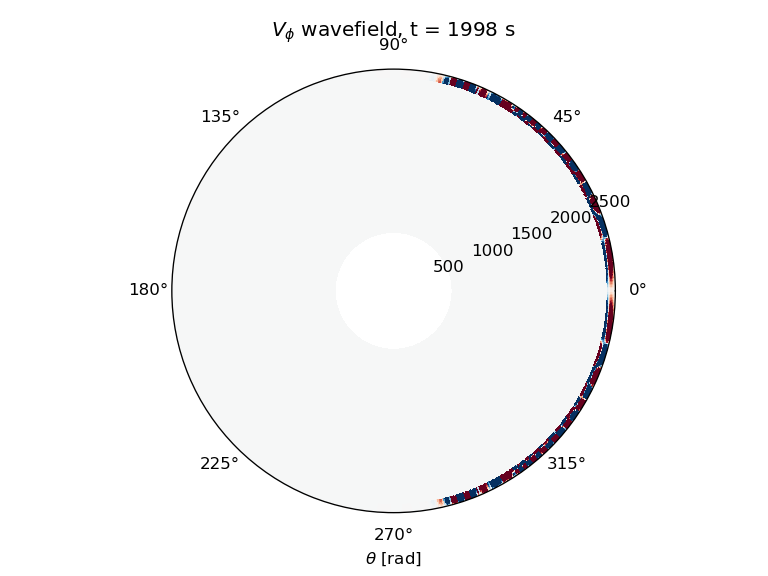

CPU times: user 7min 54s, sys: 2.87 s, total: 7min 57s
Wall time: 2min 13s


In [10]:
# Run SH FD modelling for modified Vance etal. (2017) Ganymede model
# ------------------------------------------------------------------
%matplotlib notebook

# Define source depth (m)
zsrc = 10.0 * 1000.0

# Interpolate 1D PREM model on FD grid
r    = np.arange(nr)                    # r-coordinates on FD grid
r    = rcore + r * dr                   # add core radius

# define interpolation function
rshift = 0  # shift 1D Ganymede model with respect to FD model

fvs = interpolate.interp1d(np.flipud(radius-rshift),np.flipud(vs1D),kind="nearest")
vs1D_fd = fvs(r)

frho = interpolate.interp1d(np.flipud(radius-rshift),np.flipud(rho1D),kind="nearest")
rho1D_fd = frho(r)

# build 2D vs and density Ganymede models
vs1D_ganymede_liq = np.tile(vs1D_fd, (ntheta,1))
rho1D_ganymede_liq = np.tile(rho1D_fd, (ntheta,1))

# define wavefield clip value    
clip = 3e-10

# calculate time step according to CFL criterion
dt = dr / (np.sqrt(2) * np.max(vs1D_ganymede_liq)) 

%time time_ganymede_liq, seis_ganymede_liq = FD_2D_SH_JIT(dt,dr,dtheta,f0,vs1D_ganymede_liq,rho1D_ganymede_liq,nr,ntheta,clip,zsrc)

Let's be very optimistic and assume we have an armada of space probes to place geophones at each $\theta$-gridpoint on Ganymedes surface, which would record the following seismic section:

<IPython.core.display.Javascript object>


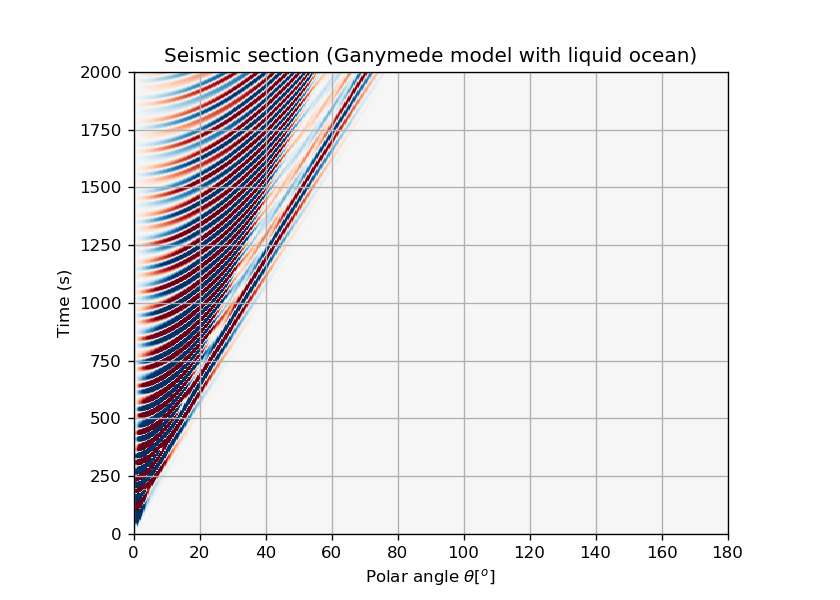

In [11]:
# Plot FD seismograms for Ganymede model with liquid ocean at polar 
# angles between 0 and 180°
# -----------------------------------------------------------------
%matplotlib notebook

# Define figure size
rcParams['figure.figsize'] = 7, 5

extent = [0,180.0,tmax,0]
clip = 1e-9
plt.imshow(seis_ganymede_liq.T, extent=extent, cmap="RdBu",vmin=-clip,vmax=clip, aspect=7e-2)

plt.title(r'Seismic section (Ganymede model with liquid ocean)')
plt.xlabel(r'Polar angle $\theta [^o]$')
plt.ylabel('Time (s)')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

Compared to the [1D PREM earth modelling results](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/07_SH_waves_in_moons_and_planets/2_2D_SHaxi_FD_modelling_earth.ipynb) and [1D moon modelling results](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/07_SH_waves_in_moons_and_planets/3_2D_SHaxi_FD_modelling_moon.ipynb) you only notice the direct $S$ wave, a very strong coda generated by reflections between the Ganymede surface and top of the liquid ocean, and a Love wave. 

If we are more realistic, we can only rely on one receiver placed at a polar angle $\theta = 22.5^o$:

<IPython.core.display.Javascript object>


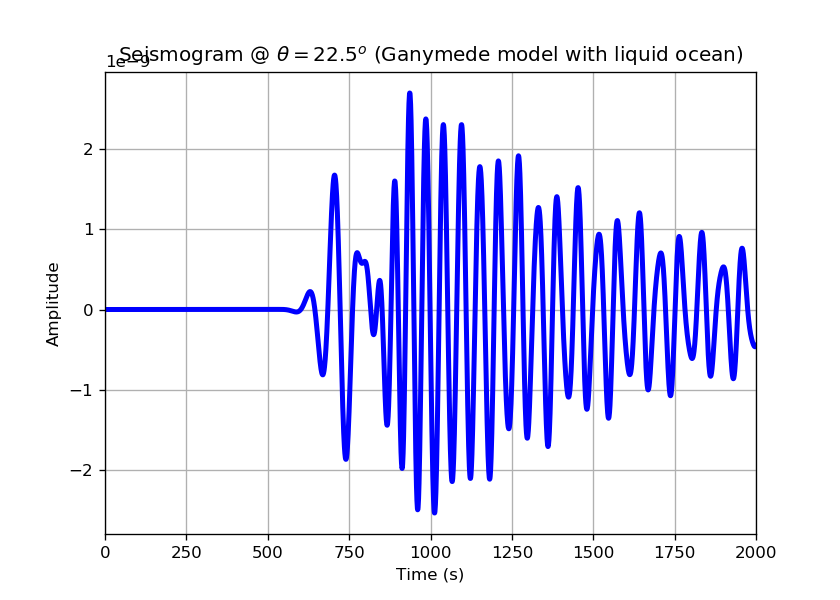

In [12]:
# Plot FD seismogram at polar angle 22.5°
# ---------------------------------------
%matplotlib notebook
# Define figure size
rcParams['figure.figsize'] = 7, 5
plt.plot(time_ganymede_liq, seis_ganymede_liq[(int)(ntheta/8),:], 'b-',lw=3,label="FD solution") # plot FD seismogram
plt.xlim(time_ganymede_liq[0], time_ganymede_liq[-1])
plt.title(r'Seismogram @ $\theta = 22.5^o$ (Ganymede model with liquid ocean)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

which is also dominated by the Coda wave.

##### Exercise

To distinguish between a liquid ocean and solid ice crust, replace the liquid ocean either by a homogeneous S-wave velocity layer with the Vs-value above the ocean or a linear velocity gradient connecting the Vs velocity values above and below the ocean.  Using this model without a liquid ocean, compute the axisymmetric SH wave propagation for the same shallow icequake in 10 km depth. Compare and discuss the seismic section for receivers placed at every $\theta$ gridpoint and single station recording at $\theta=22.5^o$ with the seismograms of the modelling run with the liquid ocean.

You can earn an extra point by borrowing an SH-geophone from Dennis Wilken and place it on the surface of Ganymede. Can you reproduce your modelling results? Does Ganymede have a liquid ocean?

## What we learned:

* Space probes revealed that the Galilean satellites are very dynamic worlds
* Using an elastic model based on a self-consistent thermodynamics model for the fluid, rock, and mineral phases according to [Vance et al. (2017)](https://arxiv.org/abs/1705.03999), we could compute the axisymmetric SH-wavefield of a shallow icequake
* The seismograms of the icequake are dominated by an S-wave coda generated by reflections between the Ganymede surface and top of the liquid ocean

## References:

1. Vance, S. D., Panning, M. P., Stähler, S., Cammarano, F., Bills, B. G., Tobie, G.,…Banerdt, B. (2018). Geophysical investigations of habitability in ice‐covered ocean worlds. Journal of Geophysical Research: Planets Planets, 123, 180–205. https://doi.org/10.1002/2017JE005341

2. Stähler, S. C., Panning, M. P., Vance, S. D., Lorenz, R. D., van Driel, M., Nissen‐Meyer, T., & Kedar, S. (2018). Seismic wave propagation in icy ocean worlds. Journal of Geophysical Research: Planets, 123, 206–232. https://doi.org/10.1002/2017JE005338

3. Panning, M. P., Stähler, S. C., Huang, H.‐H., Vance, S. D., Kedar, S., Tsai, V. C., Pike, W. T., & Lorenz, R. D. (2018). Expected seismicity and the seismic noise environment of Europa. Journal of Geophysical Research: Planets, 123, 163–179. https://doi.org/10.1002/2017JE005332

4. Vance Steven D., Kedar Sharon, Panning Mark P., Stähler Simon C., Bills Bruce G., Lorenz Ralph D., Huang Hsin-Hua, Pike W.T., Castillo Julie C., Lognonné Philippe, Tsai Victor C., and Rhoden Alyssa R. (2018). Vital Signs: Seismology of Icy Ocean Worlds. Astrobiology, 18(1), 37-53. https://doi.org/10.1089/ast.2016.1612